In [74]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from keras.utils.vis_utils import plot_model

In [76]:
def saveModel(model, filename):
    model.save(filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

In [77]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)

In [78]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [79]:
subset_df = df[df["koi_disposition"] != "CANDIDATE"]

In [80]:
X = subset_df[TO_USE].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [81]:
X = StandardScaler().fit_transform(X)
#X = PCA().fit_transform(X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)

In [83]:
def createModel():
    model = Sequential([
                    Dense(256, input_dim=X.shape[1], activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(128, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                   ])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [84]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    kappa = cohen_kappa_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Kappa Score: {kappa}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

In [85]:
def trainEvaluate(model, fold, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=20, verbose=0)
    pred = model.predict(X_test)
    pred = pred >= 0.5
    f1 = f1_score(y_test, pred)
    print(f"F1 Score in fold {fold} = {f1}")
    return f1

def crossValidation(K=10):
    kFold = KFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    k_ctr = 1
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average {K}-Fold F1 Score = {np.mean(f1_scores)}\n")
    
    k_ctr = 1
    kFold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    f1_scores = list()
    for train, test in kFold.split(X, y):
        model = None
        model = createModel()
        current_f1 = trainEvaluate(model, k_ctr, X[train], y[train], X[test], y[test])
        f1_scores.append(current_f1)
        k_ctr+=1
    print(f"Average Stratified {K}-Fold F1 Score = {np.mean(f1_scores)}")

In [63]:
crossValidation(K=10)

F1 Score in fold 1 = 0.9727272727272727
F1 Score in fold 2 = 0.9699769053117782
F1 Score in fold 3 = 0.9644444444444443
F1 Score in fold 4 = 0.9713024282560705
F1 Score in fold 5 = 0.9701149425287356
F1 Score in fold 6 = 0.9834710743801653
F1 Score in fold 7 = 0.9814432989690721
F1 Score in fold 8 = 0.9700854700854702
F1 Score in fold 9 = 0.9897750511247443
F1 Score in fold 10 = 0.972972972972973
Average 10-Fold F1 Score = 0.9746313860800727

F1 Score in fold 1 = 0.9764453961456103
F1 Score in fold 2 = 0.986784140969163
F1 Score in fold 3 = 0.96
F1 Score in fold 4 = 0.9715536105032824
F1 Score in fold 5 = 0.9780701754385964
F1 Score in fold 6 = 0.9912280701754385
F1 Score in fold 7 = 0.9826086956521739
F1 Score in fold 8 = 0.9741379310344828
F1 Score in fold 9 = 0.9846827133479211
F1 Score in fold 10 = 0.9734513274336283
Average Stratified 10-Fold F1 Score = 0.9778962060700295


In [64]:
model = createModel()
model.fit(X_train, y_train, epochs=20, verbose=0)
pred = model.predict(X_test)
pred = pred >= 0.5

In [65]:
performance(y_test, pred)

F1 Score: 0.9703752468729429
Kappa Score: 0.9556746359126207
Accuracy Score: 0.978959286162676
Confusion Matrix:
[[1508   26]
 [  19  737]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1534
           1       0.97      0.97      0.97       756

    accuracy                           0.98      2290
   macro avg       0.98      0.98      0.98      2290
weighted avg       0.98      0.98      0.98      2290



In [66]:
saveModel(model, "../model/nn-model.h5")

In [86]:
model_perm = KerasClassifier(build_fn=createModel, epochs=20, verbose=0)
model_perm.fit(X, y)
perm = PermutationImportance(model_perm, random_state=0).fit(X,y)

In [87]:
eli5.explain_weights(perm, feature_names = TO_USE)

Weight,Feature
0.1393 ± 0.0058,koi_fpflag_ss
0.1270 ± 0.0037,koi_fpflag_co
0.1089 ± 0.0056,koi_fpflag_nt
0.0629 ± 0.0040,koi_fpflag_ec
0.0517 ± 0.0037,koi_depth
0.0454 ± 0.0027,koi_duration
0.0356 ± 0.0025,koi_period
0.0337 ± 0.0033,koi_teq
0.0257 ± 0.0030,koi_steff
0.0223 ± 0.0015,koi_slogg


In [88]:
perm.feature_importances_

array([0.00394869, 0.12699234, 0.00625449, 0.1392996 , 0.06289089,
       0.00458279, 0.03559589, 0.04536675, 0.00325694, 0.02225102,
       0.00195992, 0.00723445, 0.00080702, 0.10894941, 0.00069172,
       0.05173655, 0.02568091, 0.03369358, 0.00541863])

In [89]:
order = np.argsort(perm.feature_importances_)[::-1]
sorted_importances = sorted(perm.feature_importances_, reverse = True)
sorted_features = np.asarray(TO_USE)[order]
feature_importance_df = pd.DataFrame()
feature_importance_df['Features'] = sorted_features
feature_importance_df['Importance'] = sorted_importances

In [90]:
feature_importance_df.head()

,Features,Importance
0,koi_fpflag_ss,0.139300
1,koi_fpflag_co,0.126992
2,koi_fpflag_nt,0.108949
3,koi_fpflag_ec,0.062891
4,koi_depth,0.051737


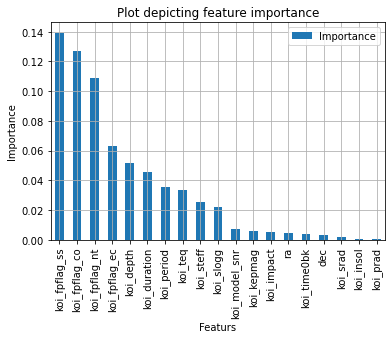

In [91]:
feature_importance_df.plot(x = 'Features', y = 'Importance', kind = 'bar')
plt.title('Plot depicting feature importance')
plt.grid()
plt.xlabel('Featurs')
plt.ylabel('Importance')
plt.savefig("feat_imp_nn.png", dpi=600)
plt.show()

In [73]:
model = createModel()
x=plot_model(model, show_shapes=True)